In [11]:
#Imports

import keras
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras import layers
from keras.layers import Input

from sklearn.metrics import precision_recall_fscore_support, classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [6]:
df_test = joblib.load('lstm_test.sav')
df_train = joblib.load('lstm_train.sav')
df_val = joblib.load('lstm_val.sav')

In [7]:
df_lstm_train = df_train[['features','label']].copy()
df_lstm_test = df_test[['features','label']].copy()
df_lstm_val = df_val[['features','label']].copy()

In [8]:
#check shapes of our new inputs
df_lstm_train.shape, df_lstm_test.shape, df_lstm_val.shape

((647, 2), (81, 2), (81, 2))

# LSTM Model on outputs


In [9]:
label_list = [x for x in np.unique(df_lstm_train['label'])]
label_list

[0, 1]

In [92]:
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
model = Model(text_input, out)


opt = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_5 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_10 (Dense)             (None, 30)                3030      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 62        
Total params: 350,692
Trainable params: 350,692
Non-trainable params: 0
_________________________________________________________________


Thanks to Armand Olivares for his post which helped on teh generator function and mask
https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d

Because chunk lengths can be different, we pad the shorter chunks with a special value, -99, which is masked and therfefore skipped for the network

In [93]:


#The generator functions (get the max length 3 batches at a time)
num_sequences = len(df_train['features'].to_list())
batch_size = 1
batches_per_epoch =  647
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['features'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['features'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [94]:
num_sequences_val = len(df_val['features'].to_list())
batch_size_val = 1
batches_per_epoch_val = 81
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['features'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['features'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [95]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [102]:
history = model.fit_generator(train_generator(df_lstm_train)
                    ,steps_per_epoch=len(df_lstm_train)
                    ,epochs=10
                    ,validation_data=val_generator(df_lstm_val)
                    ,validation_steps=len(df_lstm_val) 
                    #,callbacks =[call_reduce, es] 
                    )

Epoch 1/10
647/647 [==============================] - 5s 7ms/step - loss: 0.6191 - acc: 0.2612 - val_loss: 0.7565 - val_acc: 0.5926
Epoch 2/10
647/647 [==============================] - 5s 7ms/step - loss: 0.6151 - acc: 0.2628 - val_loss: 0.7597 - val_acc: 0.5926
Epoch 3/10
647/647 [==============================] - 5s 7ms/step - loss: 0.6118 - acc: 0.2628 - val_loss: 0.7602 - val_acc: 0.5926
Epoch 4/10
647/647 [==============================] - 5s 7ms/step - loss: 0.6078 - acc: 0.2581 - val_loss: 0.7638 - val_acc: 0.5926
Epoch 5/10
647/647 [==============================] - 5s 7ms/step - loss: 0.6041 - acc: 0.2597 - val_loss: 0.7663 - val_acc: 0.5926
Epoch 6/10
647/647 [==============================] - 5s 7ms/step - loss: 0.6004 - acc: 0.2612 - val_loss: 0.7698 - val_acc: 0.5926
Epoch 7/10
647/647 [==============================] - 5s 7ms/step - loss: 0.5965 - acc: 0.2597 - val_loss: 0.7725 - val_acc: 0.5802
Epoch 8/10
647/647 [==============================] - 5s 7ms/step - loss: 0.

# LSTM Model: Evaluation

In [103]:
num_sequences_val = len(df_test['features'].to_list())
batch_size_val = 1
batches_per_epoch_val = 81
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

[0.6179526448249817, 0.6296296119689941]

In [104]:
y_log = model.predict_generator(val_generator(df_test), steps= batches_per_epoch_val)

In [105]:
y_pred = np.argmax(y_log, axis=1)

In [106]:
# Show classification report
from sklearn.metrics import precision_recall_fscore_support, classification_report
print("LSTM split chunks")
print(classification_report(df_test['label'], y_pred))

LSTM split chunks
              precision    recall  f1-score   support

           0       0.63      0.86      0.73        37
           1       0.83      0.57      0.68        44

    accuracy                           0.70        81
   macro avg       0.73      0.72      0.70        81
weighted avg       0.74      0.70      0.70        81



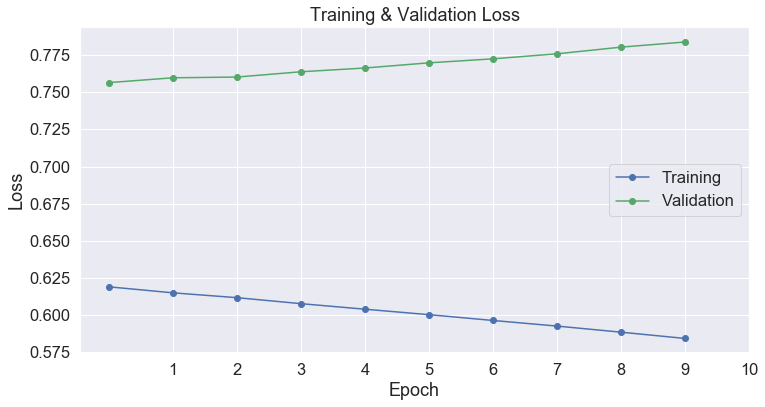

In [107]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(history.history['loss'], 'b-o', label="Training")
plt.plot(history.history['val_loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,10])

plt.show()

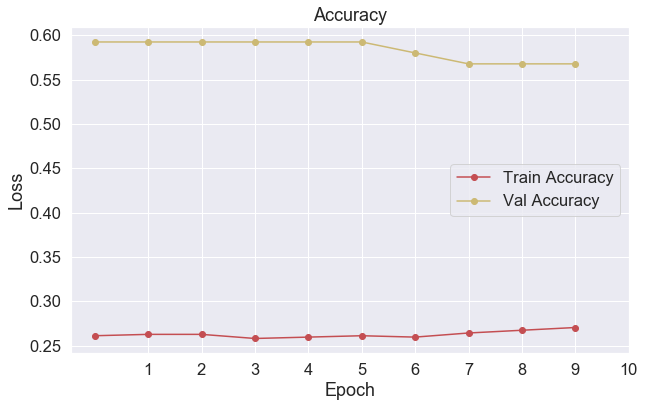

In [108]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(history.history['acc'], 'r-o', label="Train Accuracy")
plt.plot(history.history['val_acc'], 'y-o', label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,10])

plt.show()